# FYP Notebook

Import all relevant libraries

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import re
import json
pd.get_option("display.max_columns")

from datetime import datetime, timedelta, timezone
from datetime import datetime
import time
from matplotlib.dates import DateFormatter

# # Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud
#import fot plotly
import plotly.express as px
#profile report
import klib

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

In [57]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis

#optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

read csv

In [ ]:
US_videos =  pd.read_csv('Dataset\\US_youtube_trending_data.csv')
US_categories = pd.read_json('Dataset\\US_category_id.json')

In [ ]:
US_videos.head()

In [ ]:
US_videos.info()

Before Cleaning, just to see the most frequent hashtags used in the title

# Data Cleaning

Pre-process checklist

_Step 1_
- check how many numerical feature
- check how many categorical feature
- check missing value


_Step 2_

- treating missing value
- treating outliers
- normalization
- convert datatype
- filter stop words
- remove punctuation
- remove special characters
- segmentation of hashtag

In [10]:
US_videos.dtypes

video_id             object
title                object
publishedAt          object
channelId            object
channelTitle         object
categoryId            int64
trending_date        object
tags                 object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
thumbnail_link       object
comments_disabled      bool
ratings_disabled       bool
description          object
dtype: object

Specifically, in this project I will be analyzing videos only in Category People & Blog

In [11]:
# select videos only in category "People and Blog"
# from US_categories, category ID for People and Blog is 22
PB_videos = US_videos.loc[US_videos['categoryId'] == 22]

In [12]:
#How many unique channels are there?
PB_videos['channelTitle'].nunique()

754

In [ ]:
hash_word = PB_videos['title'].str.extractall(r"(#\S+)")

In [ ]:
freq_hashtag = hash_word[0].value_counts()
freq_hashtag[:20]

In [ ]:
PB_videos.head()

In [ ]:
PB_videos.shape

Checking Missing Value

In [ ]:
# check missing value
klib.missingval_plot(PB_videos)

In [13]:
#Treat missing value
PB_videos.description= PB_videos.description.fillna('', )

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\3829428351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos.description= PB_videos.description.fillna('', )


In [14]:
klib.missingval_plot(PB_videos)

No missing values found in the dataset.


find duplicated based on video_id

In [15]:
PB_videos.duplicated(subset='video_id').sum()

9477

drop duplicate and only keep last occurence (latest)

In [16]:
PB_videos.drop_duplicates(subset='video_id',keep='last', inplace=True)

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2922947673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos.drop_duplicates(subset='video_id',keep='last', inplace=True)


In [17]:
print("Size of the original dataset: {}".format(len(US_videos.loc[US_videos['categoryId'] == 22])))
print("Number of unique videos in the dataset: {}".format(len(PB_videos)))

Size of the original dataset: 11629
Number of unique videos in the dataset: 2152


In [18]:
PB_videos.drop(['thumbnail_link'], axis=1, inplace=True)
PB_videos.drop(['video_id'], axis=1, inplace=True)
PB_videos.drop(['categoryId'], axis=1, inplace=True)

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\1692840772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos.drop(['thumbnail_link'], axis=1, inplace=True)
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\1692840772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos.drop(['video_id'], axis=1, inplace=True)
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\1692840772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature Engineering part 1

In [19]:
titles_count = PB_videos['title'].value_counts()
PB_videos['trending_time'] = PB_videos.apply(lambda x: titles_count[x['title']],axis=1)
# Trending_time is the number of days in trending.

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\150206483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['trending_time'] = PB_videos.apply(lambda x: titles_count[x['title']],axis=1)


In [20]:
PB_videos['time_of_day'] = PB_videos['publishedAt'].apply(lambda x: pd.Timestamp(x).hour)

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\493044883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['time_of_day'] = PB_videos['publishedAt'].apply(lambda x: pd.Timestamp(x).hour)


In [21]:
PB_videos['Hour'] = PB_videos['publishedAt'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ').hour)

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\4193067047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['Hour'] = PB_videos['publishedAt'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ').hour)


In [22]:
numeric_col = ['view_count', 'likes', 'dislikes', 'comment_count', 'trending_time', 'Hour']
PB_videos[numeric_col] = PB_videos[numeric_col].apply(pd.to_numeric, errors= 'coerce', axis=1)

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\3789394678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos[numeric_col] = PB_videos[numeric_col].apply(pd.to_numeric, errors= 'coerce', axis=1)


In [23]:
PB_videos['publishedAt']=pd.to_datetime(PB_videos.publishedAt)
PB_videos['publishedAt'] = PB_videos['publishedAt'].dt.tz_convert(None)
PB_videos['trending_date']=pd.to_datetime(PB_videos.trending_date)
PB_videos['trending_date'] = PB_videos['trending_date'].dt.tz_convert(None)

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2438158459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['publishedAt']=pd.to_datetime(PB_videos.publishedAt)
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2438158459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['publishedAt'] = PB_videos['publishedAt'].dt.tz_convert(None)
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2438158459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [24]:
#separate publishedAt into two column for publish date and publish time 
PB_videos['publish_date'] = pd.to_datetime(PB_videos['publishedAt']).dt.date
PB_videos['publish_time'] = pd.to_datetime(PB_videos['publishedAt']).dt.time

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2582444620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['publish_date'] = pd.to_datetime(PB_videos['publishedAt']).dt.date
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2582444620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['publish_time'] = pd.to_datetime(PB_videos['publishedAt']).dt.time


In [25]:
PB_videos['day_name'] = \
pd.to_datetime(PB_videos['publish_date']).dt.day_name()

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2680445763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['day_name'] = \


# Data Cleaning for Text Fields

From Dataset, there are 3 text columns:
- title
- description
- tags

In [26]:
#remove links from the description
PB_videos.description= PB_videos.description.str.replace('http\S+|www.\S+',''\
                                      ,regex= True).str.lower()
#removing Punctuation from description
PB_videos.description = PB_videos.description.str.replace(r'[^a-zA-Z0-9]+', ' ')
PB_videos.description= PB_videos.description.str.replace(r'[0-9]+', '')

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\1479826485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos.description= PB_videos.description.str.replace('http\S+|www.\S+',''\
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\1479826485.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  PB_videos.description = PB_videos.description.str.replace(r'[^a-zA-Z0-9]+', ' ')
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\1479826485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [27]:
#remove links from the title
PB_videos.title= PB_videos.title.str.replace('http\S+|www.\S+',''\
                                      ,regex= True).str.lower()
#removing Punctuation from title
PB_videos.title= PB_videos.title.str.replace(r'[^a-zA-Z0-9]+', ' ')
PB_videos.title= PB_videos.title.str.replace(r'[0-9]+', '')

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2438587042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos.title= PB_videos.title.str.replace('http\S+|www.\S+',''\
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2438587042.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  PB_videos.title= PB_videos.title.str.replace(r'[^a-zA-Z0-9]+', ' ')
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\2438587042.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [28]:
#remove links from the description
PB_videos.tags= PB_videos.tags.str.replace('http\S+|www.\S+',''\
                                      ,regex= True).str.lower()
#removing Punctuation from description
PB_videos.tags= PB_videos.tags.str.replace(r'[^a-zA-Z0-9]+', ' ')
PB_videos.tags= PB_videos.tags.str.replace(r'[0-9]+', '')

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\3673124771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos.tags= PB_videos.tags.str.replace('http\S+|www.\S+',''\
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\3673124771.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  PB_videos.tags= PB_videos.tags.str.replace(r'[^a-zA-Z0-9]+', ' ')
C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\3673124771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [60]:
# produce universal stop_words to use for cleaning
stop_words = stopwords.words("english")
stop_words.extend(['from', 'subject', 're', 'edu', 'use','none','None','follow', 'twitter', 'social', 'instagram', 'subscribe', 'snapchat', 'youtube', 'videos', 'video'\
                  ,'channel', 'share', 'facebook', 'comment', 'like'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [30]:
# To increase the figure size
plt.rcParams['figure.figsize'] = [10, 5]

In [31]:
def generate_wordcloud(text, stop_words):
    wordcloud = WordCloud(stopwords=stop_words,max_font_size=50, max_words=150, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Exploratory Data Analysis


Top 10 most viewed videos in category "People and Blog"

In [ ]:
top_10_videos_most_viewed = PB_videos.groupby(['title']).max().sort_values('view_count',ascending=False).loc[:,'view_count'][:10]
top_10_videos_most_viewed = top_10_videos_most_viewed.reset_index()

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x = "view_count", y = "title", data = top_10_videos_most_viewed)
plt.show()

Top 10 most liked videos in category "People and Blog"

In [ ]:
top_10_videos_most_liked = PB_videos.groupby(['title']).max().sort_values('likes',ascending=False).loc[:,'likes'][:10]
top_10_videos_most_liked = top_10_videos_most_liked.reset_index()

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x = "likes", y = "title", data = top_10_videos_most_liked)
plt.show()

Top 10 most disliked videos in category "People and Blog"

In [ ]:
top_10_videos_most_disliked = PB_videos.groupby(['title']).max().sort_values('dislikes',ascending=False).loc[:,'dislikes'][:10]
top_10_videos_most_disliked = top_10_videos_most_disliked.reset_index()

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x = "dislikes", y = "title", data = top_10_videos_most_disliked)
plt.show()

In [ ]:
# generate a function to make wordcloud for EDA
def generate_wordcloud(text, stopwords):
    wordcloud = WordCloud(stopwords=stop_words,max_font_size=50, max_words=150, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Bivariate analysis

Views vs Likes

In [ ]:
sns.regplot(data=PB_videos, x='view_count', y='likes', color= 'blue')
plt.title('Regression plot for views and likes')

Views vs Dislikes

In [ ]:
sns.regplot(data=PB_videos, x='view_count', y='dislikes', color= 'red')
plt.title('Regression plot for views and dislikes')

Top 10 channels with most videos on trending

In [ ]:
trending_channels=PB_videos.groupby(['channelTitle']).size().sort_values(ascending = False).head(10)
trending_channels=trending_channels.reset_index()
trending_channels=trending_channels.rename(columns={0: 'count'})

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(y = "channelTitle", x = "count", data = trending_channels)
plt.show()

multivariate analysis

In [ ]:
klib.corr_plot(PB_videos)

In [ ]:
tag_list = " ".join(text for text in PB_videos.tags)
generate_wordcloud(tag_list, stopwords)

In [ ]:
df_cat_pandblogs = US_videos.loc[US_videos['categoryId'] == 22]

In general, what are the most used tags for videos in category 'People and Blog'?

Find out the general topic of video using highest point of engagement based on time series

In [ ]:
labels = {'view_count': 'View Count (Millions)', 'trending_date': 'Trending Date'}
fig = px.line(df_cat_pandblogs, x='trending_date', y='view_count', title='View Count Time Series for category: People and Blog', labels=labels)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title_x=0.5)
fig.show()

the spike of views over 80M occured between
- 2021-05-16 to 2021-05-23
- 2021-07-06 to 2021-07-10
- 2022-03-22 to 2022-03-26



In [ ]:
firstdateMask = (PB_videos.publishedAt > pd.Timestamp(2021,5,16)) & (PB_videos.publishedAt < pd.Timestamp(2021,5,23))

seconddateMask = (PB_videos.publishedAt > pd.Timestamp(2021,7,6)) & (PB_videos.publishedAt < pd.Timestamp(2021,7,10))

thirddateMask = (PB_videos.publishedAt > pd.Timestamp(2022,3,22)) & (PB_videos.publishedAt < pd.Timestamp(2022,3,26))

In [ ]:
first_tag_text = " ".join(text for text in PB_videos.tags[firstdateMask])
first_tag_title = " ".join(text for text in PB_videos.title[firstdateMask])
first_tag_title = first_tag_text + ' ' + first_tag_title
generate_wordcloud(first_tag_title, stopwords)

In [ ]:
second_tag_text = " ".join(text for text in PB_videos.tags[seconddateMask])
second_tag_title = " ".join(text for text in PB_videos.title[seconddateMask])
second_tag_title = second_tag_text + ' ' + second_tag_title
generate_wordcloud(second_tag_title, stopwords)

In [ ]:
third_tag_text = " ".join(text for text in PB_videos.tags[thirddateMask])
third_tag_title = " ".join(text for text in PB_videos.title[thirddateMask])
third_tag_title = third_tag_text + ' ' + third_tag_title
generate_wordcloud(third_tag_title, stopwords)

In [ ]:
PB_videos.info()

Firstly, clean and analyze the title

In [ ]:
print(PB_videos.title.unique())

# Pre-process For LDA Model

In [32]:
PB_videos['All_text'] = PB_videos.description + ' ' + PB_videos.tags + ' ' + PB_videos.title

C:\Users\tunku\AppData\Local\Temp\ipykernel_8428\519573839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PB_videos['All_text'] = PB_videos.description + ' ' + PB_videos.tags + ' ' + PB_videos.title


In [ ]:
PB_videos.drop(columns=['description', 'tags', 'title'],axis=1,inplace=True)

In [33]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
all_words = list(sent_to_words(PB_videos['All_text']))
print(all_words[:1])

[['cinemassacre', 'channel', 'update', 'recap', 'hope', 'everyone', 'is', 'safe', 'and', 'sound', 'thanks', 'for', 'watching', 'during', 'all', 'of', 'this', 'it', 'means', 'lot', 'to', 'all', 'of', 'us', 'that', 'said', 'we', 'need', 'to', 'make', 'few', 'changes', 'with', 'everything', 'going', 'on', 'in', 'the', 'world', 'james', 'and', 'mike', 'monday', 'is', 'on', 'hiatus', 'until', 'february', 'rental', 'reviews', 'is', 'cancelled', 'but', 'the', 'rr', 'guys', 'justin', 'kieran', 'tony', 'will', 'be', 'working', 'behind', 'the', 'scenes', 'and', 'will', 'guest', 'host', 'some', 'upcoming', 'videos', 'there', 'will', 'be', 'more', 'random', 'videos', 'like', 'music', 'videos', 'and', 'scripted', 'reviews', 'plus', 'monthly', 'avgn', 'and', 'ykwbs', 'the', 'new', 'release', 'schedule', 'is', 'every', 'tuesday', 'and', 'friday', 'at', 'noon', 'est', 'conventions', 'and', 'any', 'films', 'we', 'were', 'planning', 'are', 'getting', 'pushed', 'back', 'but', 'my', 'book', 'should', 'mak

In [34]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(all_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[all_words[0]]])

['cinemassacre', 'channel', 'update', 'recap', 'hope', 'everyone', 'is', 'safe', 'and', 'sound', 'thanks', 'for', 'watching', 'during', 'all', 'of', 'this', 'it', 'means', 'lot', 'to', 'all', 'of', 'us', 'that', 'said', 'we', 'need', 'to', 'make', 'few', 'changes', 'with', 'everything', 'going', 'on', 'in', 'the', 'world', 'james', 'and', 'mike', 'monday', 'is', 'on', 'hiatus', 'until', 'february', 'rental', 'reviews', 'is', 'cancelled', 'but', 'the', 'rr', 'guys', 'justin', 'kieran', 'tony', 'will', 'be', 'working', 'behind', 'the', 'scenes', 'and', 'will', 'guest', 'host', 'some', 'upcoming', 'videos', 'there', 'will', 'be', 'more', 'random', 'videos', 'like', 'music', 'videos', 'and', 'scripted', 'reviews', 'plus', 'monthly', 'avgn', 'and', 'ykwbs', 'the', 'new', 'release', 'schedule', 'is', 'every_tuesday', 'and', 'friday', 'at', 'noon', 'est', 'conventions', 'and', 'any', 'films', 'we', 'were', 'planning', 'are', 'getting', 'pushed', 'back', 'but', 'my', 'book', 'should', 'make', 

In [35]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [36]:
# make bigram function
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [37]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [39]:
# Form Bigrams
title_words_bigrams = make_bigrams(all_words)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_withnull = lemmatization(title_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

temp_df = pd.DataFrame([list(x) for x in data_lemmatized_withnull])


In [40]:
remove_nan_rows = temp_df.dropna(axis=0, how='all')

In [41]:
temp_data_lemmatized = temp_df.to_numpy().tolist()

In [42]:
data_lemmatized = remove_stopwords(temp_data_lemmatized)

In [43]:
print(data_lemmatized[:1])

[['update', 'recap', 'hope', 'safe', 'sound', 'thank', 'watch', 'mean', 'lot', 'say', 'need', 'make', 'change', 'go', 'world', 'review', 'cancel', 'guy', 'work', 'scene', 'guest', 'host', 'upcoming', 'random', 'music', 'scripted', 'review', 'monthly', 'avgn', 'ykwb', 'new', 'release', 'schedule', 'every_tuesday', 'friday', 'noon', 'est', 'convention', 'film', 'plan', 'get', 'push', 'back', 'book', 'make', 'lot', 'headway', 'year', 'new', 'game', 'come', 'fall', 'sometime', 'system', 'add', 'deluxe', 'steam', 'wishlist', 'shirt', 'dvds', 'blu', 'ray', 'amazon', 'com', 'exclusive', 'shirt', 'jamesrolfe', 'update', 'cinemassacre', 'update', 'cinemassacre', 'update', 'cinemassacre', 'update', 'update']]


In [44]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
dt_corpus = [id2word.doc2bow(text) for text in texts]

# View
print(dt_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 6), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)]]


In [45]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(dt_corpus))

Number of unique tokens: 11606
Number of documents: 2152


In [46]:
[[(id2word[id], freq) for id, freq in cp] for cp in dt_corpus[:1]]

[[('add', 1),
  ('amazon', 1),
  ('avgn', 1),
  ('back', 1),
  ('blu', 1),
  ('book', 1),
  ('cancel', 1),
  ('change', 1),
  ('cinemassacre', 3),
  ('com', 1),
  ('come', 1),
  ('convention', 1),
  ('deluxe', 1),
  ('dvds', 1),
  ('est', 1),
  ('every_tuesday', 1),
  ('exclusive', 1),
  ('fall', 1),
  ('film', 1),
  ('friday', 1),
  ('game', 1),
  ('get', 1),
  ('go', 1),
  ('guest', 1),
  ('guy', 1),
  ('headway', 1),
  ('hope', 1),
  ('host', 1),
  ('jamesrolfe', 1),
  ('lot', 2),
  ('make', 2),
  ('mean', 1),
  ('monthly', 1),
  ('music', 1),
  ('need', 1),
  ('new', 2),
  ('noon', 1),
  ('plan', 1),
  ('push', 1),
  ('random', 1),
  ('ray', 1),
  ('recap', 1),
  ('release', 1),
  ('review', 2),
  ('safe', 1),
  ('say', 1),
  ('scene', 1),
  ('schedule', 1),
  ('scripted', 1),
  ('shirt', 2),
  ('sometime', 1),
  ('sound', 1),
  ('steam', 1),
  ('system', 1),
  ('thank', 1),
  ('upcoming', 1),
  ('update', 6),
  ('watch', 1),
  ('wishlist', 1),
  ('work', 1),
  ('world', 1),
  ('ye

In [47]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=dt_corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [48]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[dt_corpus]

[(0,
  '0.013*"getty" + 0.009*"new" + 0.007*"vogue" + 0.007*"try_not" + '
  '0.006*"courage" + 0.006*"funny" + 0.006*"know" + 0.006*"fashion" + '
  '0.006*"fortnite" + 0.005*"home"'),
 (1,
  '0.010*"get" + 0.009*"make" + 0.009*"vlog" + 0.007*"official" + '
  '0.006*"voice" + 0.006*"family" + 0.006*"thank" + 0.006*"go" + 0.005*"first" '
  '+ 0.005*"water"'),
 (2,
  '0.032*"family" + 0.019*"vlog" + 0.017*"baby" + 0.011*"pregnant" + '
  '0.009*"new" + 0.008*"life" + 0.008*"story" + 0.008*"day" + 0.007*"get" + '
  '0.007*"tiktok"'),
 (3,
  '0.013*"make" + 0.009*"tiktok" + 0.008*"hour" + 0.007*"challenge" + '
  '0.007*"music" + 0.007*"minecraft" + 0.007*"build" + 0.006*"real_life" + '
  '0.006*"eat" + 0.006*"among_us"'),
 (4,
  '0.011*"show" + 0.010*"roblox_bedwar" + 0.008*"tonight_show" + 0.007*"get" + '
  '0.006*"new" + 0.006*"go" + 0.006*"trick" + 0.005*"season" + 0.005*"good" + '
  '0.005*"friend"'),
 (5,
  '0.014*"good" + 0.010*"click" + 0.010*"watch" + 0.010*"dude_perfect" + '
  '0.00

In [49]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dt_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.052504510308617

Coherence Score:  0.39207974265541246


0.35944259744198476

In [50]:
# To plot at Jupyter notebook
pyLDAvis.enable_notebook()
plotbasemodel = pyLDAvis.gensim_models.prepare(lda_model, dt_corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plotbasemodel, 'LDA_base_model.html')
plotbasemodel

c:\Users\tunku\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.095848 -0.025386       1        1  16.983152
3     -0.042450  0.068777       2        1  13.365398
7      0.083801 -0.057555       3        1  11.449583
6      0.022258  0.045364       4        1  10.563383
8     -0.007122 -0.095423       5        1  10.093363
1      0.077876  0.010134       6        1  10.058212
0     -0.175662 -0.092679       7        1   8.228405
5      0.063131 -0.027334       8        1   8.191059
9     -0.035326  0.159076       9        1   5.703309
4     -0.082353  0.015026      10        1   5.364136, topic_info=           Term        Freq       Total Category  logprob  loglift
4038  minecraft  302.000000  302.000000  Default  30.0000  30.0000
260      family  817.000000  817.000000  Default  29.0000  29.0000
107        vlog  724.000000  724.000000  Default  28.0000  28.0000
3082      getty  104.000000  104.000000  Default  27.0000  27.0000
63         baby  442.000000  442.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1179        car   14.990773   76.014019  Topic10  -5.7944   1.3020
73         live   16.409412  219.102127  Topic10  -5.7040   0.3338
135        find   16.110830  242.458843  Topic10  -5.7224   0.2141
216       learn   14.410617  104.092609  Topic10  -5.8339   0.9481
875       today   14.511594  154.230902  Topic10  -5.8269   0.5619

[728 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2501       1  0.158285  absolute_b
2501       8  0.791424  absolute_b
11197      3  0.853613       actin
3885       1  0.076793          ad
3885       3  0.134388          ad
...      ...       ...         ...
61         9  0.031654        year
61        10  0.082300        year
8877       3  0.887084        yurt
8877       9  0.059139        yurt
11420      1  0.951768  zach_bryan

[1983 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 8, 7, 9, 2, 1, 6, 10, 5])

In [51]:
import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8'})
## Setup mallet path change it according to your drive
mallet_path = 'C:/mallet-2.0.8/bin/mallet'

start_time = time.time()
##
## Train LDA with mallet
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dt_corpus, num_topics=10, id2word=id2word)
## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))
pprint(ldamallet.show_topics(formatted=False))



--- 49.165077209472656 seconds ---
[(0,
  [('music', 0.045260076559333486),
   ('show', 0.03771673046611124),
   ('official', 0.03118666966899347),
   ('podcast', 0.015649628462058095),
   ('voice', 0.015649628462058095),
   ('talk', 0.014861517676199055),
   ('season', 0.014073406890340014),
   ('song', 0.013285296104480973),
   ('watch', 0.011709074532762891),
   ('hope', 0.010808376491781131)]),
 (1,
  [('minecraft', 0.03921096944912196),
   ('dream', 0.028987250420976666),
   ('story', 0.025739716141448158),
   ('today', 0.016598508539812366),
   ('year', 0.01599711330286264),
   ('world', 0.013471253307673804),
   ('people', 0.013350974260283859),
   ('live', 0.012148183786384412),
   ('end', 0.010103439980755352),
   ('find', 0.00950204474380563)]),
 (2,
  [('tiktok', 0.05020555624766413),
   ('funny', 0.04335368132552635),
   ('challenge', 0.026037124704123584),
   ('prank', 0.024915908807773765),
   ('part', 0.024542170175657158),
   ('game', 0.018064033885635978),
   ('among_u

In [52]:
# Compute Coherence Score for mallet
coherence_model_lda = gensim.models.CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3625829063426432


0.365307724851063

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dt_corpus, texts=data_lemmatized, start=2, limit=40, step=2)

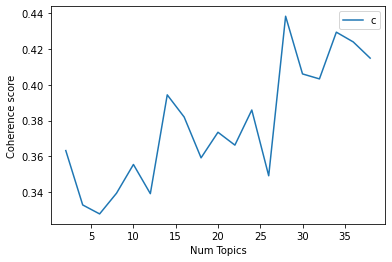

In [59]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

From coherence values computed, I choose number of topic, k=12.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

In [ ]:
final_ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=dt_corpus, num_topics=12, id2word=id2word)

In [ ]:
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) # original function has 'eta=0' argument
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

ldagensim = convertldaMalletToldaGen(final_ldamallet)

In [ ]:
vis_finallda = gensimvis.prepare(ldagensim, dt_corpus, id2word, sort_topics=False)
pyLDAvis.save_html(vis_finallda, 'LDA_final_model.html')
pyLDAvis.display(vis_finallda)

by default hyperparameters for LDA Mallet:
- alpha = 5.0
- beta = 0.01

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=dt_corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=dt_corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

In [ ]:
df_dominant_topic.to_csv(r'D:\Sem 8\FYP2\temp\Dominant Topic dataset.csv', index = False)

# Data Division

In [ ]:
X = df_dominant_topic.Text

In [ ]:
Y = df_dominant_topic.Dominant_Topic

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state = 0)

# Model Evaluation

Bag-of-Word Model

In [ ]:
# Applying bag of words to features in training and testing data
bag_of_words_creator = CountVectorizer()
X_train_bow = bag_of_words_creator.fit_transform(X_train)
X_test_bow = bag_of_words_creator.transform(X_test)

In [ ]:
cl = RandomForestClassifier(random_state = 0)
cl.fit(X_train_bow,Y_train)

In [ ]:
y_pred = cl.predict(X_test_bow)

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met

In [ ]:
confusion_matrix(Y_test,y_pred)

In [ ]:
print(met.classification_report(Y_test,y_pred))

TF-IDF model

In [ ]:
tfidf_creator = TfidfVectorizer()
X_train_tfidf = tfidf_creator.fit_transform(X_train)
X_test_tfidf = tfidf_creator.transform(X_test)

In [ ]:
cl = RandomForestClassifier(random_state = 0)
cl.fit(X_train_tfidf,Y_train)

In [ ]:
y_pred = cl.predict(X_test_tfidf)

In [ ]:
confusion_matrix(Y_test,y_pred)

In [ ]:
print(met.classification_report(Y_test,y_pred))